In [1]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
import astropy.coordinates as coord

%matplotlib inline
plt.style.use('/jet/home/tvnguyen/mplstyle/default.mplstyle')

In [2]:
catalog_root = '/ocean/projects/phy210068p/shared/gaia_catalogs/'
data_name = 'GaiaDR3_FeH_reduced_v1'
labels_name = 'GaiaDR3_FeH_reduced_v4'
features = ('ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'is_accreted')
plotdir = '/jet/home/tvnguyen/accreted_catalog/gaia_accreted_catalog/notebooks/figures/v4'
os.makedirs(plotdir, exist_ok=True)

catalog = {k: [] for k in features}
catalog['score'] = []
catalog['index'] = []
for i in range(10):
    data_path = os.path.join(catalog_root, data_name, f'data.{i}.hdf5')
    labels_path = os.path.join(catalog_root, labels_name, f'labels.{i}.hdf5')
    print(f'Loading data from {data_path} and {labels_path}')

    with h5py.File(labels_path, 'r') as f:
        score = f['score'][:]
        label_source_id = f['source_id'][:]
        index = f['index'][:]
    catalog['score'].append(score)
    catalog['index'].append(index)

    with h5py.File(data_path, 'r') as f:
        for k in features:
            catalog[k].append(f[k][:][index]) 

for key in catalog:
    catalog[key] = np.concatenate(catalog[key], axis=0)

Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v1/data.0.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v4/labels.0.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v1/data.1.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v4/labels.1.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v1/data.2.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v4/labels.2.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v1/data.3.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v4/labels.3.hdf5
Loading data from /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v1/data.4.hdf5 and /ocean/projects/phy210068p/shared/gaia_catalogs/GaiaDR3_FeH_reduced_v4/labels.4.hdf5
Loading data from /ocean/projects/phy210068p/share

In [3]:
# convert from RA, Dec, parallax, pmra, pmdec, radial_velocity to Galactocentric coordinates
distance = coord.Distance(parallax=catalog['parallax']*u.mas).to(u.kpc)
c = coord.SkyCoord(
    ra=catalog['ra']*u.deg, dec=catalog['dec']*u.deg,
    pm_ra_cosdec=catalog['pmra']*u.mas/u.yr, pm_dec=catalog['pmdec']*u.mas/u.yr,
    radial_velocity=catalog['radial_velocity']*u.km/u.s,
    distance=distance,
    frame='icrs'
)
galcen = c.transform_to(coord.Galactocentric)

In [4]:
def convert_to_cylindrical_velocity(x, y, z, vx, vy, vz):
    """ return R, phi, z, vR, vT, vz """
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    vR = (x*vx + y*vy)/R
    vT = (x*vy - y*vx)/R
    return R, phi, z, vR, vT, vz

x = galcen.x.to(u.kpc).value
y = galcen.y.to(u.kpc).value
z = galcen.z.to(u.kpc).value
vx = galcen.v_x.to(u.km/u.s).value
vy = galcen.v_y.to(u.km/u.s).value
vz = galcen.v_z.to(u.km/u.s).value
R, phi, z, vR, vT, vz = convert_to_cylindrical_velocity(x, y, z, vx, vy, vz)

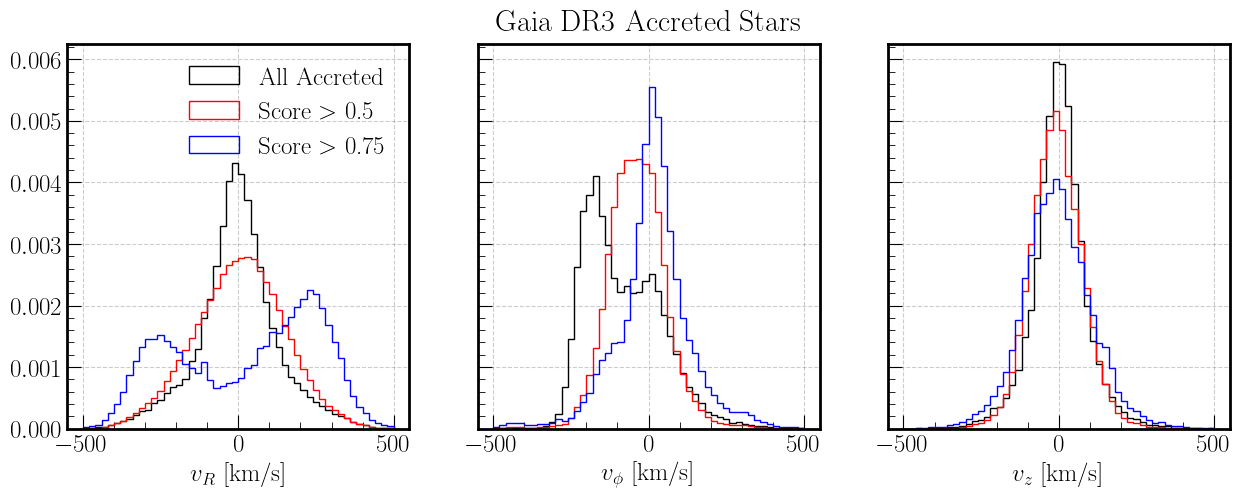

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

score = catalog['score']
true_label = catalog['is_accreted']
label1 = score > 0.5
label2 = score > 0.75

axes[0].hist(
    vR[true_label], bins=50, range=(-500, 500), density=True,
    histtype='step', color='k', label='All Accreted')
axes[0].hist(
    vR[label1], bins=50, range=(-500, 500), density=True,
    histtype='step', color='r', label='Score $>$ 0.5')
axes[0].hist(
    vR[label2], bins=50, range=(-500, 500), density=True,
    histtype='step', color='b', label='Score $>$ 0.75')

axes[1].hist(
    vT[true_label], bins=50, range=(-500, 500), density=True,
    histtype='step', color='k')
axes[1].hist(
    vT[label1], bins=50, range=(-500, 500), density=True,
    histtype='step', color='r')
axes[1].hist(
    vT[label2], bins=50, range=(-500, 500), density=True,
    histtype='step', color='b')

axes[2].hist(
    vz[true_label], bins=50, range=(-500, 500), density=True,
    histtype='step', color='k')
axes[2].hist(
    vz[label1], bins=50, range=(-500, 500), density=True,
    histtype='step', color='r')
axes[2].hist(
    vz[label2], bins=50, range=(-500, 500), density=True,
    histtype='step', color='b')

axes[0].set_xlabel(r'$v_R$ [km/s]')
axes[1].set_xlabel(r'$v_\phi$ [km/s]')
axes[2].set_xlabel(r'$v_z$ [km/s]')
axes[0].legend()
axes[1].set_title('Gaia DR3 Accreted Stars')

plt.show()
fig.savefig(
    os.path.join(plotdir, 'vdist.png'), dpi=300, bbox_inches='tight')

In [6]:
def calc_chi2(v, score, true_label, bins, thres):
    """ Caculate chi2 for a given velocity component between the 
    true accreted stars and the predicted accreted stars """
    v_true = v[true_label]

    chi2 = np.zeros(len(thres))
    for i, t in enumerate(thres):
        label = score > t
        v_pred = v[label]
        hist_true, _ = np.histogram(v_true, bins=bins, density=True)
        hist_pred, _ = np.histogram(v_pred, bins=bins, density=True)
        chi2[i] = np.sum((hist_true - hist_pred)**2)
    return chi2


def eff(y_true, y_score, thresholds):
    """ Get the efficiency and purity for a given threshold """
    epsilon_0 = []  # efficiency for class 0
    epsilon_1 = []  # efficiency for class 1
    purity = []  # purity for class 1
    for threshold in thresholds:
        y_pred = (y_score > threshold)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        epsilon_0.append(fp / (tn + fp))
        epsilon_1.append(tp / (tp + fn))
        purity.append(tp / (tp + fp))
    return np.array(epsilon_0), np.array(epsilon_1), np.array(purity)

In [7]:
threshold = np.linspace(0.01, 0.99, 100)
bins = np.linspace(-500, 500, 50)

# ROC curve
epsilon_0, epsilon_1, purity = eff(true_label, score, threshold)

# chi2 between the true and predicted velocity distribution
chi2_vR = calc_chi2(vR, score, true_label, bins, threshold)
chi2_vT = calc_chi2(vT, score, true_label, bins, threshold)
chi2_vz = calc_chi2(vz, score, true_label, bins, threshold)
chi2 = chi2_vR + chi2_vT + chi2_vz

chi2_vR_norm = chi2_vR / np.min(chi2_vR)
chi2_vT_norm = chi2_vT / np.min(chi2_vT)
chi2_vz_norm = chi2_vz / np.min(chi2_vz)
chi2_norm = chi2 / np.min(chi2)

best_threshold = threshold[np.argmin(chi2)]

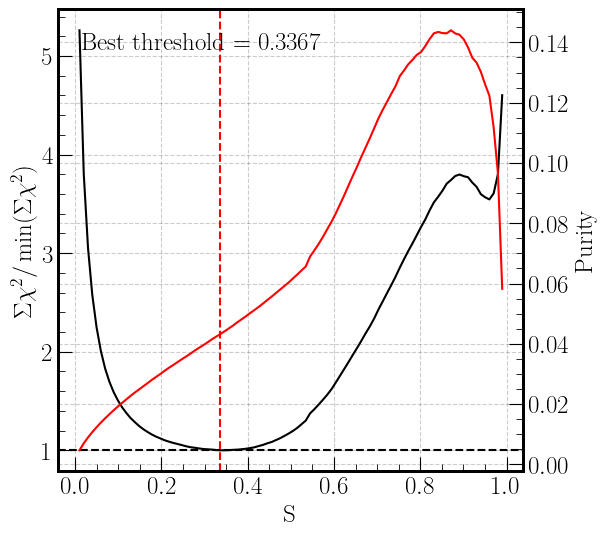

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(threshold, chi2_norm, color='k')
ax.axvline(best_threshold, color='r', linestyle='--')
ax.axhline(1, color='k', linestyle='--')
ax.set_xlabel('S')
ax.set_ylabel(r'$\Sigma\chi^2 / \min(\Sigma\chi^2)$')
ax.text(
    0.05, 0.95, f'Best threshold = {best_threshold:.4f}', 
    ha='left', va='top', transform=ax.transAxes)

# create a twin y axis to show the purity
ax2 = ax.twinx()
ax2.plot(threshold, purity, color='r')
ax2.set_ylabel('Purity')

plt.show()
fig.savefig(
    os.path.join(plotdir, 'chi2.png'), dpi=300, bbox_inches='tight')

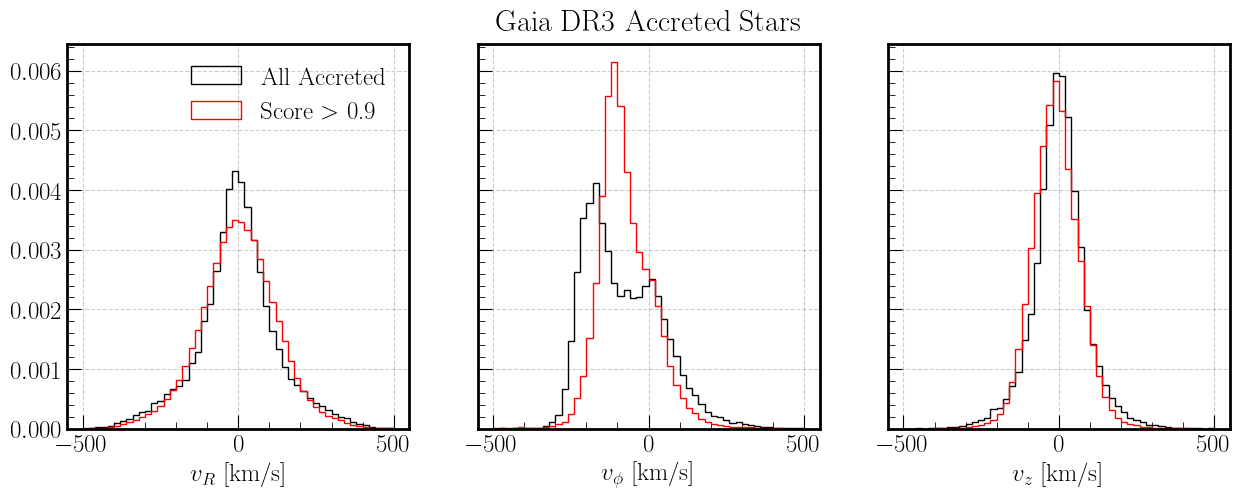

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

score = catalog['score']
true_label = catalog['is_accreted']
label1 = score > best_threshold

axes[0].hist(
    vR[true_label], bins=50, range=(-500, 500), density=True,
    histtype='step', color='k', label='All Accreted')
axes[0].hist(
    vR[label1], bins=50, range=(-500, 500), density=True,
    histtype='step', color='r', label='Score $>$ 0.9')

axes[1].hist(
    vT[true_label], bins=50, range=(-500, 500), density=True,
    histtype='step', color='k')
axes[1].hist(
    vT[label1], bins=50, range=(-500, 500), density=True,
    histtype='step', color='r')

axes[2].hist(
    vz[true_label], bins=50, range=(-500, 500), density=True,
    histtype='step', color='k')
axes[2].hist(
    vz[label1], bins=50, range=(-500, 500), density=True,
    histtype='step', color='r')

axes[0].set_xlabel(r'$v_R$ [km/s]')
axes[1].set_xlabel(r'$v_\phi$ [km/s]')
axes[2].set_xlabel(r'$v_z$ [km/s]')
axes[0].legend()
axes[1].set_title('Gaia DR3 Accreted Stars')

plt.show()
fig.savefig(
    os.path.join(plotdir, 'vdist_highscore.png'), dpi=300, bbox_inches='tight')

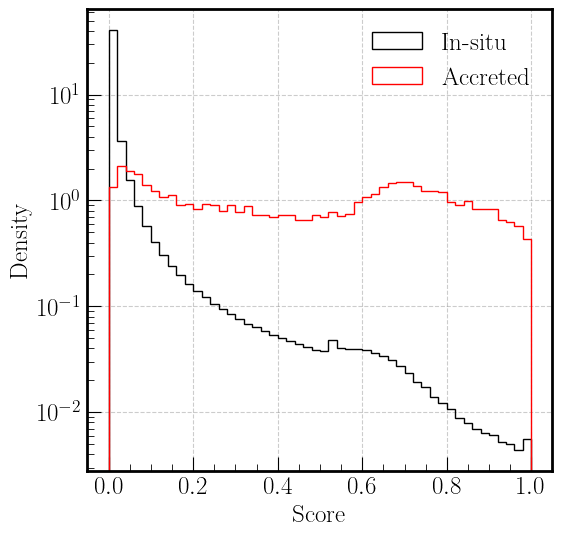

In [10]:
fig, ax = plt.subplots()

ax.hist(
    score[~true_label], bins=50, range=(0, 1), density=True, 
    histtype='step', color='k', label='In-situ')
ax.hist(
    score[true_label], bins=50, range=(0, 1), density=True, 
    histtype='step', color='r', label='Accreted')
ax.set_xlabel('Score')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()

plt.show()
fig.savefig(
    os.path.join(plotdir, 'score.png'), dpi=300, bbox_inches='tight')